In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
 
import tensorflow as tf
import pathlib
import random
import matplotlib.pyplot as plt

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 100

In [5]:
data_root_orig_train = '../R2HandRilDataset/Train'
data_root_train = pathlib.Path(data_root_orig_train)
data_root_orig_test = '../R2HandRilDataset/Test'
data_root_test = pathlib.Path(data_root_orig_test)

In [6]:
train_image_paths = list(data_root_train.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

image_count = len(train_image_paths)

In [7]:
test_image_paths = list(data_root_test.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths]
random.shuffle(test_image_paths)

image_count = len(test_image_paths)

In [8]:
train_image_paths = list(data_root_train.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

In [9]:
test_image_paths = list(data_root_test.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths]
random.shuffle(test_image_paths)

In [10]:
train_label_names = sorted(item.name for item in data_root_train.glob('*/') if item.is_dir())
test_label_names = sorted(item.name for item in data_root_test.glob('*/') if item.is_dir())
train_label_to_index = dict((name, index) for index, name in enumerate(train_label_names))
test_label_to_index = dict((name, index) for index, name in enumerate(test_label_names))


In [11]:
train_image_labels = [train_label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths]


In [12]:
test_image_labels = [test_label_to_index[pathlib.Path(path).parent.name]
                    for path in test_image_paths]


In [13]:
def preprocess_image(image):
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image /= 255.0

    return image

In [14]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [15]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)

train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_labels, tf.int64))

train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

In [16]:
train_ds = train_image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [17]:
test_ds = test_image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=124, 
                                 kernel_size=(3, 3), 
                                 activation='relu', 
                                 padding='valid',
                                 input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(filters=124, 
                                 kernel_size=(3, 3), 
                                 activation='relu', 
                                 padding='valid'))
model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=596, 
                                 kernel_size=(3, 3), 
                                 activation='relu', 
                                 padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=596, 
                                 kernel_size=(3, 3), 
                                 activation='relu', 
                                 padding='valid'))
model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=1192, 
                                 kernel_size=(3, 3), 
                                 activation='relu', 
                                 padding='valid'))
model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1192, activation='relu'))
model.add(tf.keras.layers.Dense(62, activation='softmax'))

In [19]:
len(model.trainable_variables)

14

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 124)       1240      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 124)       138508    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 124)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 596)       665732    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 596)         3197540   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 596)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 1192)        6

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999, 
                                                 epsilon=1e-07, 
                                                 amsgrad=False,
                                                 name='Adam'),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
steps_per_epoch=tf.math.ceil(len(train_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

2325.0

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds, epochs=100, steps_per_epoch=2325, validation_data=test_ds, validation_steps=930)

Epoch 1/100
2325/2325 [==============================] - 72s 31ms/step - loss: 0.1512 - accuracy: 0.9428 - val_loss: 0.4300 - val_accuracy: 0.8715
Epoch 2/100
2325/2325 [==============================] - 73s 31ms/step - loss: 0.1504 - accuracy: 0.9427 - val_loss: 0.4327 - val_accuracy: 0.8710
Epoch 3/100
2325/2325 [==============================] - 73s 31ms/step - loss: 0.1505 - accuracy: 0.9423 - val_loss: 0.4321 - val_accuracy: 0.8706
Epoch 4/100
2325/2325 [==============================] - 73s 31ms/step - loss: 0.1509 - accuracy: 0.9426 - val_loss: 0.4324 - val_accuracy: 0.8706
Epoch 5/100
2325/2325 [==============================] - 73s 32ms/step - loss: 0.1496 - accuracy: 0.9426 - val_loss: 0.4273 - val_accuracy: 0.8709
Epoch 6/100
2325/2325 [==============================] - 73s 32ms/step - loss: 0.1495 - accuracy: 0.9434 - val_loss: 0.4314 - val_accuracy: 0.8715
Epoch 7/100
2325/2325 [==============================] - 72s 31ms/step - loss: 0.1495 - accuracy: 0.9431 - val_loss: 0

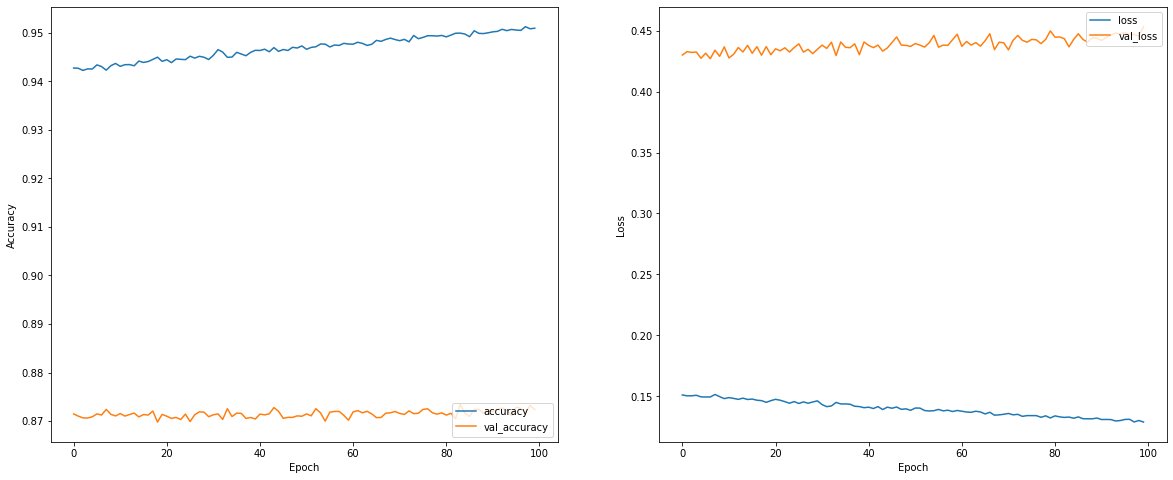

In [37]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [35]:
model.save('Recognition_RusHandRilNet_new_arch_v4.2.h5')